## PS6
```
Fiona Fan
```

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import random
from sklearn.tree import export_graphviz
import graphviz


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
biden = pd.read_csv('biden.csv', sep=',')
biden.dropna(inplace=True)
biden.head()

biden  female  age  educ  dem  rep
0     90       0   19    12    1    0
1     70       1   51    14    1    0
2     60       0   27    14    0    0
3     50       1   43    14    1    0
4     60       1   38    14    0    1

In [3]:
X = biden[['female', 'age', 'educ', 'dem', 'rep']].values
y = biden.biden.values

random.seed()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3,
                                                    random_state=25)
biden_tree1 = DecisionTreeRegressor( min_samples_leaf=5)
biden_tree1.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

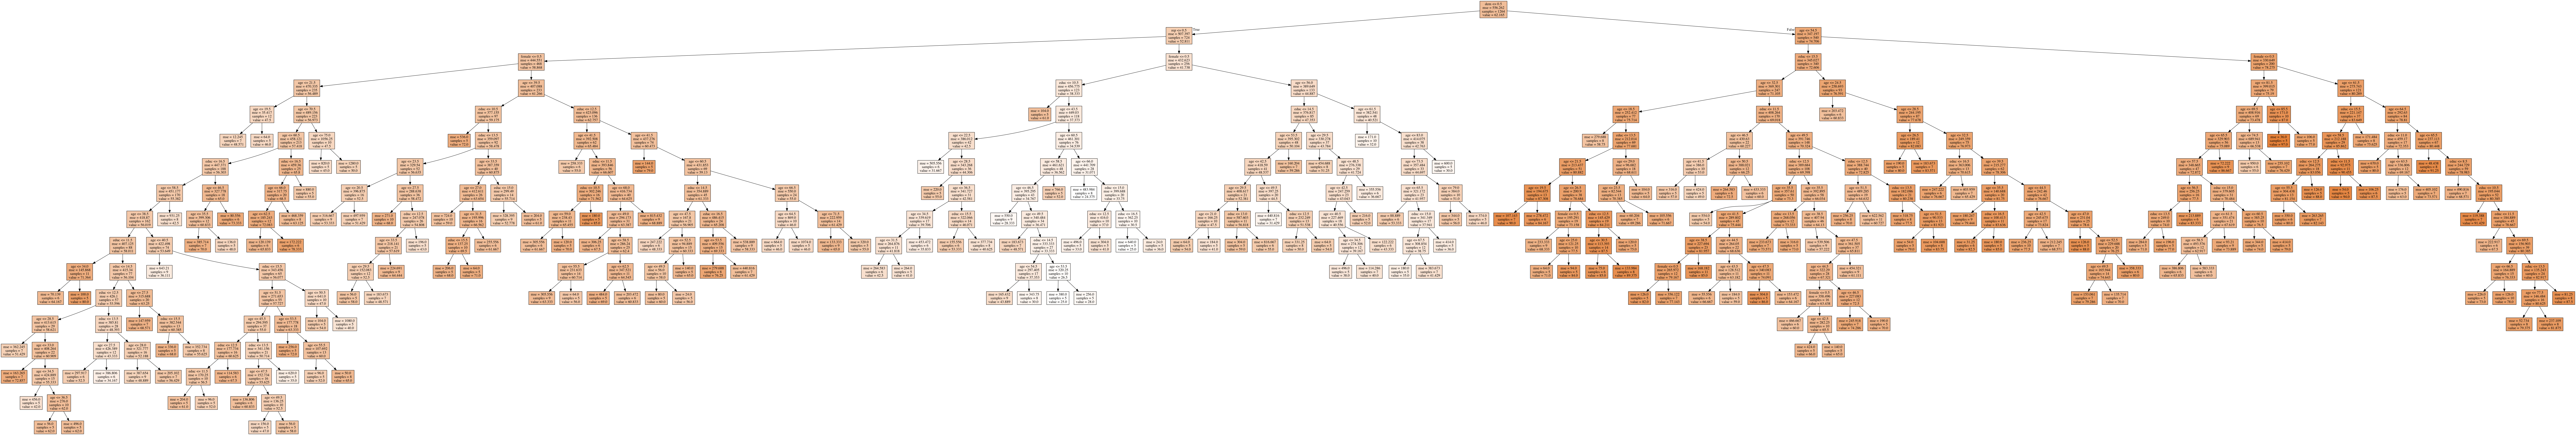

In [4]:
from sklearn.externals.six import StringIO 
import pydot
from IPython.display import Image

def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)
graph2, = print_tree(biden_tree1, features=['female', 'age', 'educ', 'dem', 'rep'])
# im = Image(graph2.create_png())

graph2.write_pdf("out.pdf")
Image (graph2.create_png())


For simplicity I will only discuss the first three layers. The first split is whether the person is democratic or not (dem). On average, the democrats like Biden more than non-Democrats. For non-Democrats, the next cut is classified by whether they are Republican. Republicans like Biden much less than people not belonging to Demcrats or Republicans. For both the Republicans and the non-Democrat-non-Republicans, the next cut happens at whether the person is female. For both groups, females like Biden better than non-females. Now, going to the right side of the graph, for the Democrats, the second cut happens for age. People aged more than 54.5 are more likely to like Biden. For the older Democrats, like the non-Democrats, females like Biden more. For the younger Democrats, if they have received more than 15.5 years education, they are more likely to like Biden. For more details please see "out.pdf".

In [5]:
y_pred = biden_tree1.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 480.7245051302462


## 1b)

In [6]:
MSE_list = []
for i in range(50):
    temp_tree =DecisionTreeRegressor(max_depth=i+1, min_samples_leaf=5)
    temp_tree.fit(X_train, y_train)
    y_pred_temp = temp_tree.predict(X_test)
    MSE_list.append(mean_squared_error(y_test, y_pred_temp))
print(f'The optimal level of trees is {MSE_list.index(min(MSE_list))+1}, with MSE {min(MSE_list)}')
print (f'The pruned tree has reduced MSE. ')
print (f'For intepretation please see above.')

The optimal level of trees is 3, with MSE 396.1937146321307
The pruned tree has reduced MSE. 
For intepretation please see above.


## 1C)

In [7]:
from sklearn.ensemble import BaggingRegressor
biden_tree2 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=15)
biden_tree2.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=15, verbose=0, warm_start=False)

In [8]:
biden_tree2.score(X, y)
y_pred2 = biden_tree2.oob_prediction_
MSE3 = mean_squared_error(y, y_pred2)
print('MSE=', MSE3)

MSE= 406.0005583949261


In [9]:
importances = np.mean([
    tree.feature_importances_ for tree in biden_tree2.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

print("Feature ranking:")
features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(len(features)):
    print(f'{f+1}. {features[f]}:,{importances[indices[f]]}')

Feature ranking:
1. female:,0.4429127039606069
2. age:,0.20057625971613363
3. dem:,0.19032354439169072
4. rep:,0.10602822551257896
5. educ:,0.06015926641898977


female is the variable with most importance in the tree model, followed by age and dem with half of female's imporance, followed by rep with even halved importance.

## 1d

In [10]:
from sklearn.ensemble import RandomForestRegressor

B=53
MSE_rf=[]
for m in range(3):
    print (f'm is {m+1}')
    temp = RandomForestRegressor(n_estimators=B, max_features=m+1, bootstrap=True,
                                  oob_score=True, random_state=25)
    temp.fit(X, y)

    temp.score(X, y)
    y_pred_rf = temp.oob_prediction_
    MSE = mean_squared_error(y, y_pred_rf)
    print('MSE=', MSE)
    MSE_rf.append(MSE)

# calculate variable importances
    importances = temp.feature_importances_
    std = np.std([tree.feature_importances_ for tree in temp.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # print the rankings of features
    
    print("Feature Ranking:")
    for f in range(len(features)):
        print(f'{f+1}. {features[f]}:,{importances[indices[f]]}')
    print()

m is 1
MSE= 538.3230397820951
Feature Ranking:
1. female:,0.5217927469927922
2. age:,0.1713135511547811
3. dem:,0.1496895941226878
4. rep:,0.1359043825432276
5. educ:,0.02129972518651136

m is 2
MSE= 539.5640797270379
Feature Ranking:
1. female:,0.5143102974424522
2. age:,0.18090644405234227
3. dem:,0.15367364292562752
4. rep:,0.13076353025316306
5. educ:,0.020346085326414954

m is 3
MSE= 536.6073956886949
Feature Ranking:
1. female:,0.48925354836121593
2. age:,0.20228598973438028
3. dem:,0.16922077182891992
4. rep:,0.11010334643594882
5. educ:,0.02913634363953492



Across all m's, the ranking of importance of features remaims the same: female is the most salient, ensued by age, dem and rep with similar salience, while educ is the least salient. There is no monotonic relationship betwen m and MSE. In this case, MSE is smallest with m=3.